In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import time
import lightgbm as lgb

from sklearn.model_selection import GroupKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn import metrics

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [2]:
DATA_PATH = "data/"

submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

In [3]:
df_train

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [4]:
df_test

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


id - globally-unique time step identifier across an entire file  
breath_id - globally-unique time step for breaths  
R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.  
C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.  
time_step - the actual time stamp.  
u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.  
u_out - the control input for the exploratory solenoid valve. Either 0 or 1.  
pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.  

## Feature exploration
We want to observe how the features evolve in several random breath cycles

In [5]:
np.random.seed(88)
n_rows = 7
n_cols = 2
def plot_sample(df, n_rows, n_cols):
    n_cycles = n_rows * n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 5*n_rows))
    breath_ids = df_train.breath_id.sample(n_cycles).values
    
    for row in range(n_rows):
        for col in range(n_cols):
            breath_id = breath_ids[row*n_cols+col]
            df_breath = df[df['breath_id'] == breath_id]
            assert df_breath.drop_duplicates(subset=['R', 'C']).shape[0] == 1
            [r, c] = df_breath.drop_duplicates(subset=['R', 'C'])[['R', 'C']]

            for col_name in ['u_in', 'u_out', 'pressure']:
                axs[row, col].plot(df_breath['time_step'], df_breath[col_name], label=col_name)
            axs[row, col].legend()
            plt.title(f'Sample {breath_id} - R={r}, C={c}')
            axs[row, col].grid(True)

#plot_sample(df_train, 5, 2)

<AxesSubplot:>

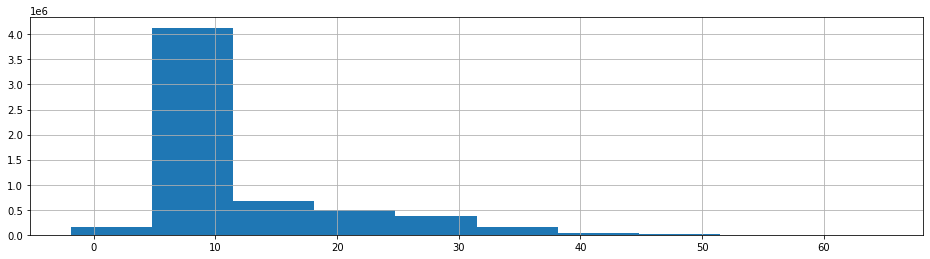

In [6]:
df_train.pressure.hist(figsize=(16,4))

In [7]:
def feature_engineering(df):
    df['last_value_u_in'] = df.groupby('breath_id')['u_in'].transform('last')
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df = df.fillna(0)

    # max value of u_in and u_out for each breath
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')

    df['breath_id__u_in__min'] = df.groupby(['breath_id'])['u_in'].transform('min')
    df['breath_id__u_out__min'] = df.groupby(['breath_id'])['u_out'].transform('min')

    # difference between consequitive values
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    # from here: https://www.kaggle.com/yasufuminakama/ventilator-pressure-lstm-starter
    df.loc[df['time_step'] == 0, 'u_in_diff'] = 0
    df.loc[df['time_step'] == 0, 'u_out_diff'] = 0

    # difference between the current value of u_in and the max value within the breath
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

    # OHE
    df = df.merge(pd.get_dummies(df['R'], prefix='R'), left_index=True, right_index=True).drop(['R'], axis=1)
    df = df.merge(pd.get_dummies(df['C'], prefix='C'), left_index=True, right_index=True).drop(['C'], axis=1)
    df = df.merge(pd.get_dummies(df['R__C'], prefix='R__C'), left_index=True, right_index=True).drop(['R__C'], axis=1)

    # https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/273974
    df['u_in_cumsum'] = df.groupby(['breath_id'])['u_in'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    
    return df

df_train = feature_engineering(df_train)
# remove entries with 0 u_out from the training set
df_train = df_train[df_train.u_out==1]

df_test = feature_engineering(df_test)

In [8]:
def optimize_parameters(X, y, groups, n_splits=5, max_evals=20):
    # define fixed hyperparameters
    params = {'objective': 'regression_l1',
              'learning_rate': 0.25,
              "boosting_type": "gbdt",
              'min_data_in_leaf':600,
              'max_bin': 196,
              #'device':'gpu',
              'feature_fraction':0.4,
              'lambda_l1':36, 'lambda_l2':80,
              'max_depth':16,
              'num_leaves':1000,
              "metric": 'mae',
              'n_jobs': -1
             }
    
    # define floating hyperparameters
    space = {
        'n_estimators': hp.quniform('n_estimators', 6000, 12000, 500),
        'max_depth': hp.quniform('max_depth', 16, 20, 1),
        'num_leaves': hp.quniform('num_leaves', 1000, 2000, 50),
        'objective': hp.choice('loss', ['regression', 'regression_l1', 'quantile', 'mape'])
    }
    # define the objective function to optimize the hyperparameters
    def objective(floating_params):
        params['n_estimators'] = int(floating_params['n_estimators'])
        params['max_depth'] = int(floating_params['max_depth'])
        params['num_leaves'] = int(floating_params['num_leaves'])
        scores = []
        model = lgb.LGBMRegressor(**params)
        model.fit(X, y, verbose=-1)
        score = metrics.mean_absolute_error(y, model.predict(X))
        return score

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals)
    
    best['num_iterations'] =  1500
    best['n_estimators'] = int(best['n_estimators']); best['max_depth'] = int(best['max_depth']); 
    best['num_leaves'] = int(best['num_leaves'])
    
    return best

# Lgbm parameter tuning

In [ ]:
columns = [col for col in df_train.columns if col not in ['id', 'pressure', 'breath_id']]
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
subset = df_train[df_train.breath_id.isin(range(100000))]
X = subset[columns]
y = subset['pressure'] #sc.fit_transform(df_train['pressure'].values.reshape(-1,1)).flatten()
params = {'objective': 'regression_l1', # 'regression'
          'learning_rate': 0.25,
          "boosting_type": "gbdt",
          'min_data_in_leaf':600,
          'max_bin': 196,
          #'device':'gpu',
          'feature_fraction':0.4,
          'lambda_l1':36, 'lambda_l2':80,
          'max_depth':16,
          'num_leaves':1000,
          "metric": 'mae',
          'n_jobs': -1
         }
params = optimize_parameters(X, y, subset['breath_id'])

[LightGBM] [Warning] lambda_l1 is set=36, reg_alpha=0.0 will be ignored. Current value: lambda_l1=36
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
  0%|                                    | 0/20 [00:00<?, ?trial/s, best loss=?]

In [ ]:
scores = []
X = df_train[columns]
groups = df_train['breath_id']
y = df_train['pressure']
feature_importance = pd.DataFrame()
models = []
folds = GroupKFold(n_splits=5)
for fold_n, (train_index, valid_index) in enumerate(folds.split(X[columns], y, groups=groups)):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators=8000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=100, early_stopping_rounds=10)
    score = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
    
    models.append(model)
    scores.append(score)

    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

In [ ]:
feature_importance["importance"] /= 5
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)')

In [ ]:
for model in models[:-1]:
    submission['pressure'] += model.predict(df_test[columns])
submission['pressure'] /= 4

In [ ]:
submission.to_csv('submissions.csv', index=False)

In [ ]:
from numba import cuda

cuda.select_device(0)
cuda.close()